In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import xgboost as xgb
import statsmodels.api as sm


c:\Users\melmora\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data

In [3]:
# Load the new voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_relative'] = ML_df['T5']/ML_df['T0']
ML_df['T5_relativebin'] = ML_df['T5_relative'] >= 1

ML_df['T5_more_than_45'] = ML_df['T5'] > 45
ML_df['T5_recovered'] = (ML_df['T5_relativebin']) & (ML_df['T5_more_than_45'])


### Data Imputation

In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume ML_df is your DataFrame
# data_clean is data met Imputation
# data is data zonder imputation
data_clean = ML_df.copy()
data = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80 - removed
# if 'T5' in data_clean.columns:
#     data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
data_clean

# Output the missing values check
missing_values_final_check.sum()

# t5_cleaned = data_clean['T5_relative'].replace([np.inf, -np.inf], np.nan).dropna()

# Define features and target
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_relativebin', 'T5_more_than_45', 'T5_recovered'])
y = data_clean['T5_more_than_45']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


### Best Modelling - 0.85

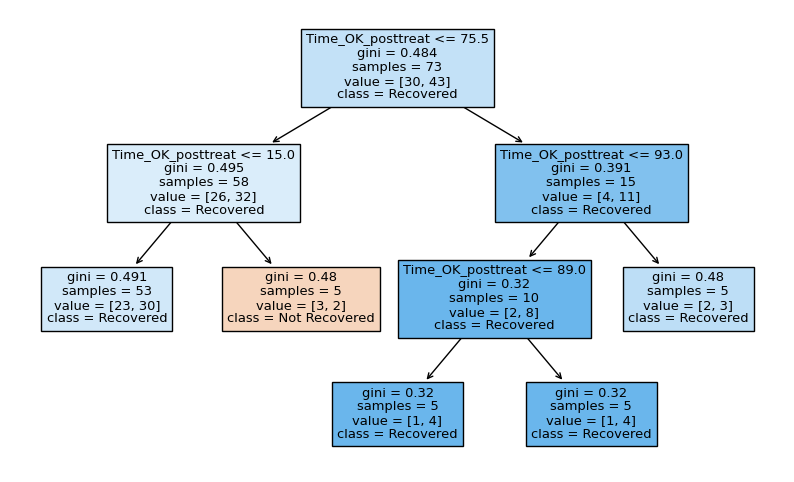

                 Model  Accuracy  Precision    Recall  Specificity        F1
0  Logistic Regression   0.75000   0.703704  1.000000     0.384615  0.826087
1        Decision Tree   0.71875   0.692308  0.947368     0.384615  0.800000
2              XGBoost   0.75000   0.739130  0.894737     0.538462  0.809524
3           Null Model   0.59375   0.593750  1.000000     0.000000  0.745098


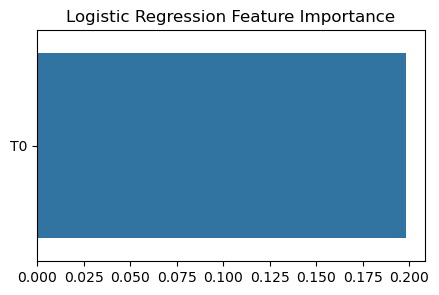

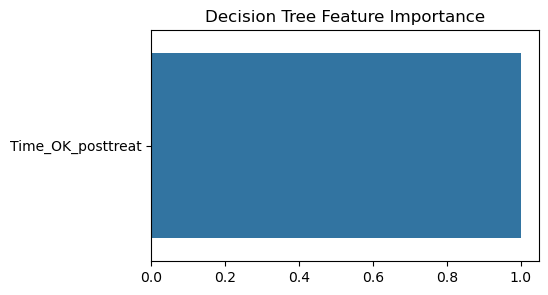

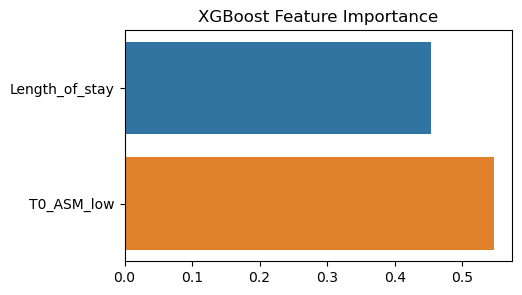

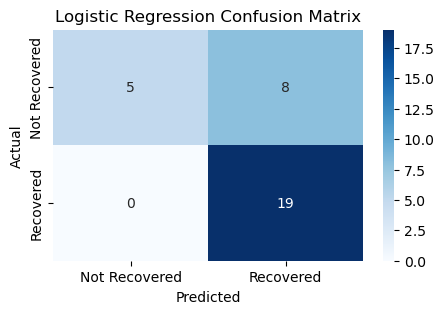

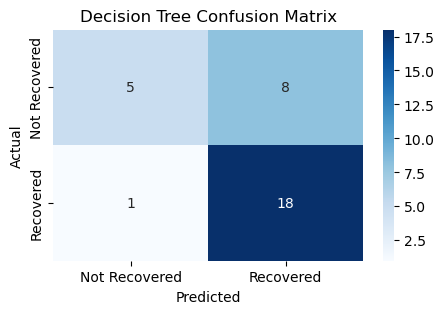

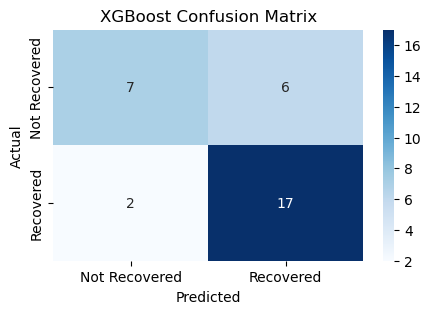

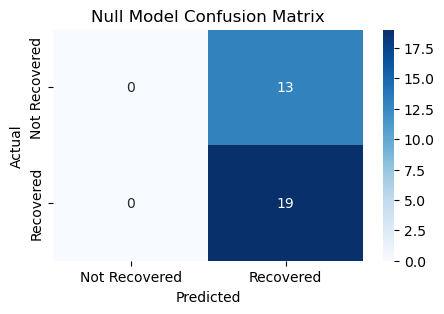

In [12]:
# Forward feature selection
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    best_features, initial_features, best_score = [], [], 0
    while True:
        scores = [(accuracy_score(y_test, model.fit(X_train[initial_features + [f]], y_train).predict(X_test[initial_features + [f]])), f) for f in X_train.columns if f not in initial_features]
        if not scores: break
        current_score, best_feature = sorted(scores, reverse=True)[0]
        if current_score > best_score:
            best_score = current_score
            initial_features.append(best_feature)
            best_features.append(best_feature)
        else: break
    return best_features

# Metrics function
def calculate_metrics(y_true, y_pred):
    acc, prec, rec, f1 = accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'Specificity': tn / (tn + fp), 'F1': f1}

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recovered', 'Recovered'], yticklabels=['Not Recovered', 'Recovered'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Train and evaluate models
def train_evaluate_model(model, name):
    features = forward_feature_selection(model, X_train, y_train, X_test, y_test)
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    metrics = calculate_metrics(y_test, y_pred)
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else np.abs(model.coef_[0])
    return metrics, features, importances

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
metrics_log_reg, features_log_reg, importances_log_reg = train_evaluate_model(log_reg, 'Logistic Regression')

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15, min_samples_leaf=5)
metrics_tree, features_tree, importances_tree = train_evaluate_model(tree_model, 'Decision Tree')

# Plot Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(tree_model, feature_names=features_tree, class_names=['Not Recovered', 'Recovered'], filled=True)
plt.show()

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
metrics_xgb, features_xgb, importances_xgb = train_evaluate_model(xgb_model, 'XGBoost')

# Null Model
class NullModel:  # Dummy model that predicts the majority class
    def fit(self, X, y): self.mode = y.mode()[0]
    def predict(self, X): return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)
y_test_pred_null = null_model.predict(X_test)
metrics_null = calculate_metrics(y_test, y_test_pred_null)

# Feature importance plot
def plot_feature_importance(importances, features, title):
    plt.figure(figsize=(5, 3))
    sns.barplot(x=importances, y=features)
    plt.title(f'{title} Feature Importance')
    plt.show()

# Display results and plots
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Null Model'],
    'Accuracy': [metrics_log_reg['Accuracy'], metrics_tree['Accuracy'], metrics_xgb['Accuracy'], metrics_null['Accuracy']],
    'Precision': [metrics_log_reg['Precision'], metrics_tree['Precision'], metrics_xgb['Precision'], metrics_null['Precision']],
    'Recall': [metrics_log_reg['Recall'], metrics_tree['Recall'], metrics_xgb['Recall'], metrics_null['Recall']],
    'Specificity': [metrics_log_reg['Specificity'], metrics_tree['Specificity'], metrics_xgb['Specificity'], metrics_null['Specificity']],
    'F1': [metrics_log_reg['F1'], metrics_tree['F1'], metrics_xgb['F1'], metrics_null['F1']]
})
print(metrics_df)

plot_feature_importance(importances_log_reg, features_log_reg, 'Logistic Regression')
plot_feature_importance(importances_tree, features_tree, 'Decision Tree')
plot_feature_importance(importances_xgb, features_xgb, 'XGBoost')

plot_conf_matrix(y_test, log_reg.predict(X_test[features_log_reg]), 'Logistic Regression')
plot_conf_matrix(y_test, tree_model.predict(X_test[features_tree]), 'Decision Tree')
plot_conf_matrix(y_test, xgb_model.predict(X_test[features_xgb]), 'XGBoost')
plot_conf_matrix(y_test, y_test_pred_null, 'Null Model')

In [10]:
log_reg.coef_

array([[0.19842867]])

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


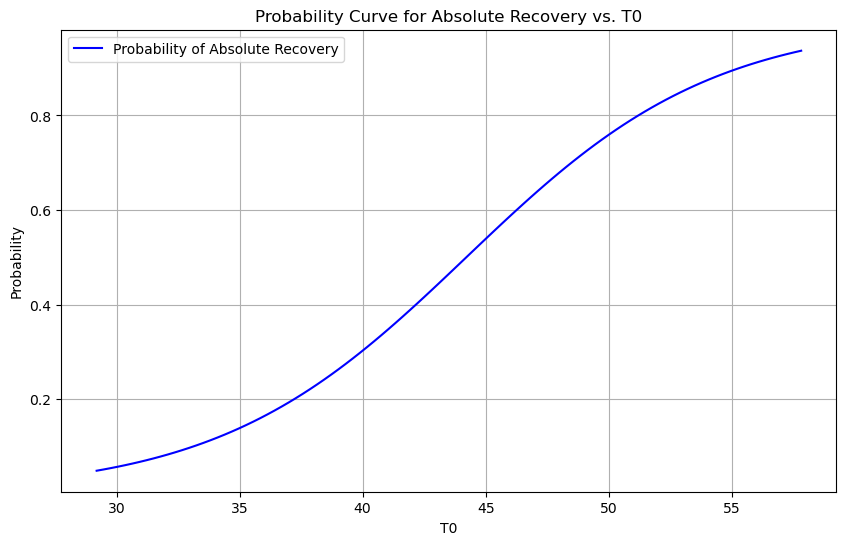

In [11]:
# Generate a range of values for T0
t0_range = np.linspace(X_train['T0'].min(), X_train['T0'].max(), 100).reshape(-1, 1)

# Compute the probabilities for the range of T0 values
probabilities = log_reg.predict_proba(t0_range)[:, 1]

# Plot the probability curve
plt.figure(figsize=(10, 6))
plt.plot(t0_range, probabilities, label='Probability of Absolute Recovery', color='blue')
plt.xlabel('T0')
plt.ylabel('Probability')
plt.title('Probability Curve for Absolute Recovery vs. T0')
plt.grid(True)
plt.legend()
plt.show()

### T0 force

Initial accuracy with T0: 0.59375
Best features: ['T0', 'Time_pretreat_OK', 'T0_coping_cat']
{'Accuracy': 0.75, 'Precision': 0.7391304347826086, 'Recall': 0.8947368421052632, 'Specificity': 0.5384615384615384, 'F1': 0.8095238095238095}


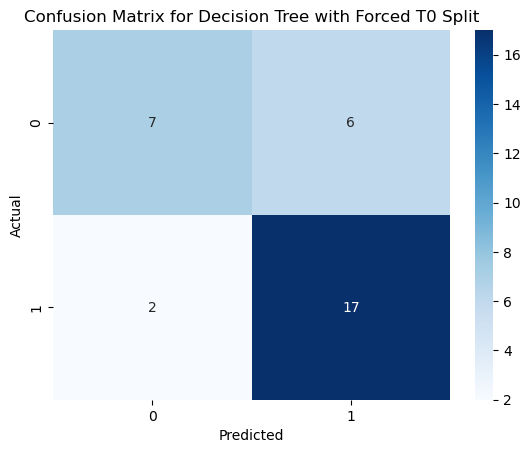

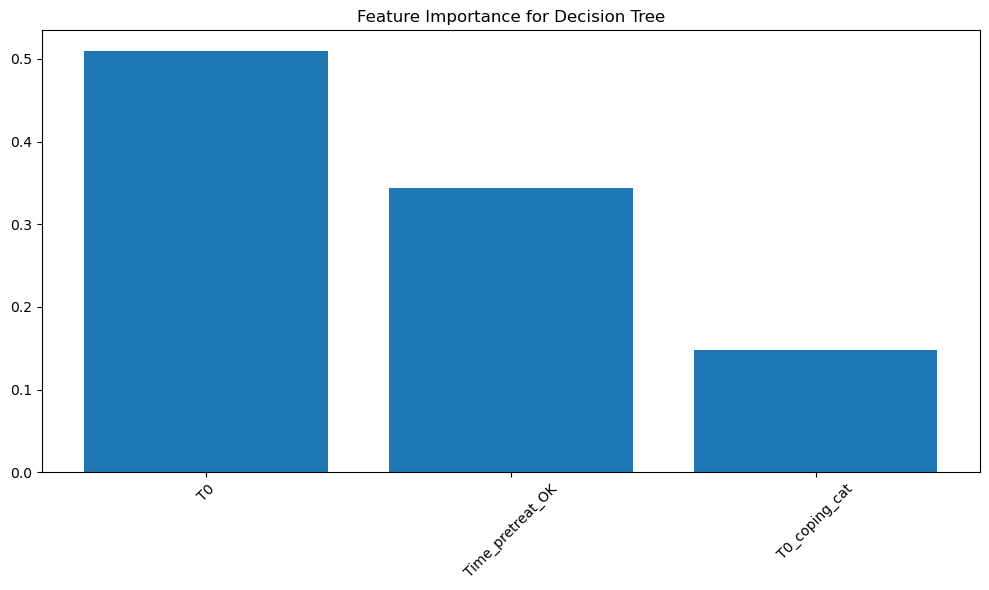

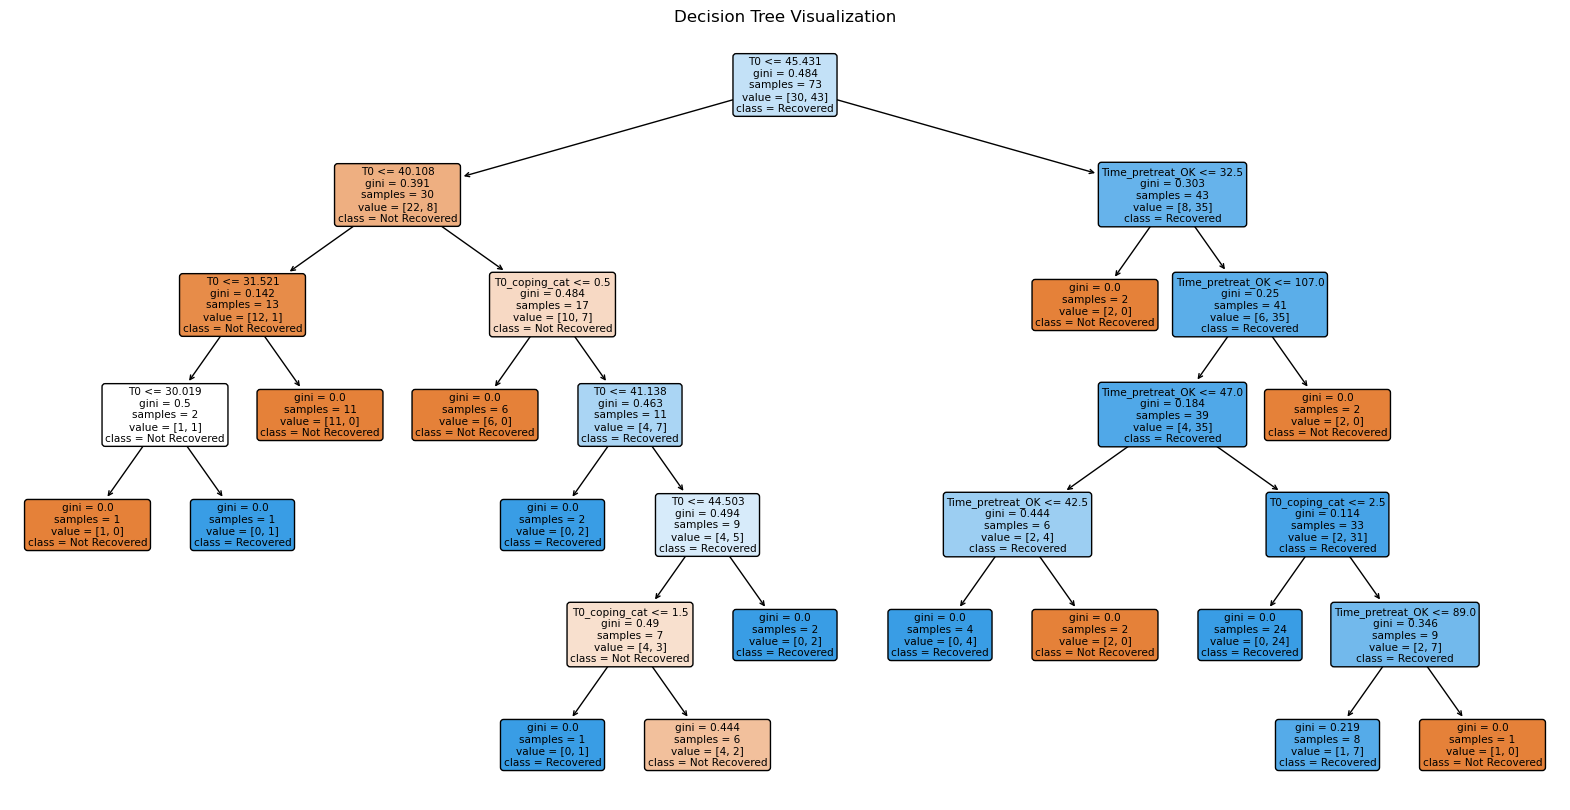

In [16]:
# Step 1: Force the first split to use only T0
def forward_feature_selection_with_T0(model, X_train, y_train, X_test, y_test):
    initial_features = ['T0']  # Start with T0 as the only feature
    best_features = ['T0']  # Force T0 to be selected first
    best_score = 0

    # First, fit the model with only T0
    model.fit(X_train[['T0']], y_train)
    y_pred = model.predict(X_test[['T0']])
    best_score = accuracy_score(y_test, y_pred)

    print(f"Initial accuracy with T0: {best_score}")

    # Step 2: Add other features using forward selection
    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = best_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        if not scores:
            break

        # Get the best feature from the current iteration
        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1': f1
    }

# Step 3: Apply the new feature selection to a Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15)

# Use forward selection, forcing T0 as the first feature
best_features_tree = forward_feature_selection_with_T0(tree_model, X_train, y_train, X_test, y_test)

# Fit the final model using the selected features
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred_tree = tree_model.predict(X_test[best_features_tree])

# Calculate the metrics
metrics_tree = calculate_metrics(y_test, y_test_pred_tree)
print(f"Best features: {best_features_tree}")
print(metrics_tree)

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree with Forced T0 Split')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance Plot
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for Decision Tree")
plt.bar(range(len(best_features_tree)), importances[indices], align="center")
plt.xticks(range(len(best_features_tree)), [best_features_tree[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=best_features_tree, 
          class_names=['Not Recovered', 'Recovered'], 
          filled=True, 
          rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


In [15]:
y_train

143     True
100     True
129    False
146     True
67     False
       ...  
18     False
136    False
150     True
140    False
8       True
Name: T5_more_than_45, Length: 73, dtype: bool

### Traditional Statistics

Bootstrap Validation - Mean Accuracy: 0.5514, Std Dev: 0.0877
                      Method  Accuracy  Precision    Recall        F1
0       Bootstrap Validation  0.551375        NaN       NaN       NaN
1  Shrinkage and Calibration  0.593750   0.636364  0.736842  0.682927
2         Backward Selection  0.593750   0.593750  1.000000  0.745098


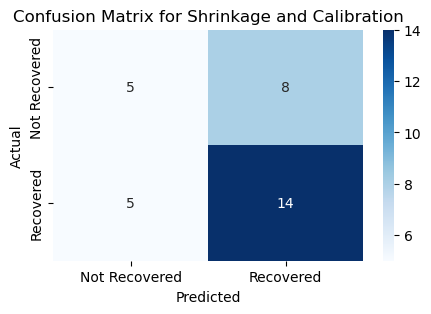

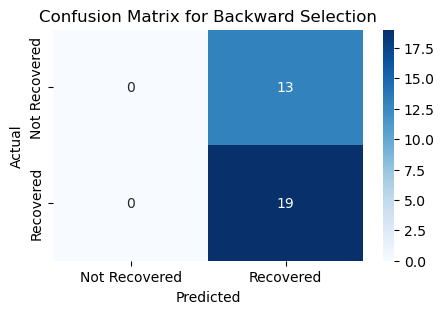

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train, y_test are already defined

# Bootstrap Validation
def bootstrap_validation(X_train, y_train, model, n_iterations=250):
    bootstrapped_scores = []
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X_train, y_train, replace=True)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        bootstrapped_scores.append(accuracy)
    return np.mean(bootstrapped_scores), np.std(bootstrapped_scores)

# Shrinkage and Calibration
def shrinkage_and_calibration(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Apply shrinkage factor (For demo, using a factor of 0.8)
    shrinkage_factor = 0.8
    y_pred = (y_pred_proba * shrinkage_factor > 0.5).astype(int)
    return y_pred

# Backward Selection
def backward_selection(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=10000)
    rfe = RFE(model, n_features_to_select=1)
    rfe.fit(X_train, y_train)
    ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(X_train.columns, ranking) if rank == 1]
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_test[selected_features])
    return y_pred, selected_features

# Define models
logistic_model = LogisticRegression(max_iter=10000)

# Bootstrap Validation
mean_acc, std_acc = bootstrap_validation(X_train, y_train, logistic_model)
print(f'Bootstrap Validation - Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}')

# Shrinkage and Calibration
y_pred_shrinkage = shrinkage_and_calibration(X_train, y_train, X_test, y_test)
metrics_shrinkage = {
    'Accuracy': accuracy_score(y_test, y_pred_shrinkage),
    'Precision': precision_score(y_test, y_pred_shrinkage),
    'Recall': recall_score(y_test, y_pred_shrinkage),
    'F1': f1_score(y_test, y_pred_shrinkage)
}

# Backward Selection
y_pred_backward, selected_features = backward_selection(X_train, y_train, X_test, y_test)
metrics_backward = {
    'Accuracy': accuracy_score(y_test, y_pred_backward),
    'Precision': precision_score(y_test, y_pred_backward),
    'Recall': recall_score(y_test, y_pred_backward),
    'F1': f1_score(y_test, y_pred_backward)
}

# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Method': ['Bootstrap Validation', 'Shrinkage and Calibration', 'Backward Selection'],
    'Accuracy': [mean_acc, metrics_shrinkage['Accuracy'], metrics_backward['Accuracy']],
    'Precision': [np.nan, metrics_shrinkage['Precision'], metrics_backward['Precision']],
    'Recall': [np.nan, metrics_shrinkage['Recall'], metrics_backward['Recall']],
    'F1': [np.nan, metrics_shrinkage['F1'], metrics_backward['F1']]
})

print(results_df)

# Plot confusion matrix for Shrinkage and Calibration
conf_matrix_shrinkage = confusion_matrix(y_test, y_pred_shrinkage)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_shrinkage, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recovered', 'Recovered'], yticklabels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Shrinkage and Calibration')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for Backward Selection
conf_matrix_backward = confusion_matrix(y_test, y_pred_backward)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_backward, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recovered', 'Recovered'], yticklabels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Backward Selection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Backward Selection using Recursive Feature Elimination (RFE)
def backward_selection(X_train, y_train, X_test, y_test, n_features_to_select=1):
    # Initialize the logistic regression model
    model = LogisticRegression(max_iter=10000)
    
    # Use RFE for backward feature elimination
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X_train, y_train)
    
    # Selected features
    selected_features = X_train.columns[rfe.support_].tolist()
    
    # Train model with selected features
    model.fit(X_train[selected_features], y_train)
    
    # Predictions and evaluation on training data
    y_train_pred = model.predict(X_train[selected_features])
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    
    # Predictions and evaluation on test data
    y_test_pred = model.predict(X_test[selected_features])
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Results
    results = {
        'Selected Features': selected_features,
        'Train Accuracy': train_accuracy,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1': train_f1,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1': test_f1
    }
    
    return results

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Example usage
results = backward_selection(X_train_scaled, y_train, X_test_scaled, y_test, n_features_to_select=5)

# Print results
print("Selected Features:", results['Selected Features'])
print("Train Accuracy:", results['Train Accuracy'])
print("Train Precision:", results['Train Precision'])
print("Train Recall:", results['Train Recall'])
print("Train F1:", results['Train F1'])
print("Test Accuracy:", results['Test Accuracy'])
print("Test Precision:", results['Test Precision'])
print("Test Recall:", results['Test Recall'])
print("Test F1:", results['Test F1'])


Selected Features: ['pat_sexe', 'T0_Tumorsize', 'T0_eetlust', 't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0']
Train Accuracy: 0.821917808219178
Train Precision: 0.8409090909090909
Train Recall: 0.8604651162790697
Train F1: 0.8505747126436781
Test Accuracy: 0.5
Test Precision: 0.5652173913043478
Test Recall: 0.6842105263157895
Test F1: 0.6190476190476191


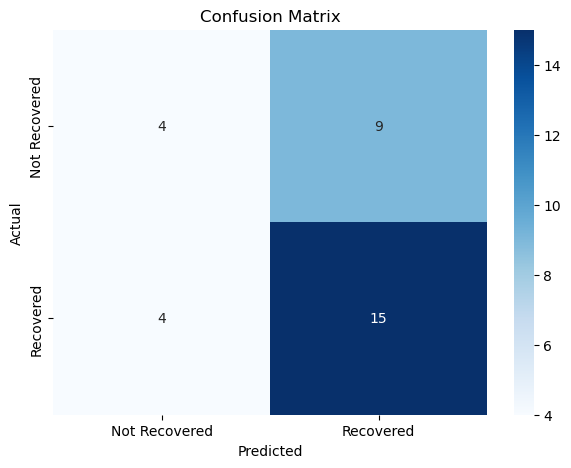

In [30]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recovered', 'Recovered'], yticklabels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Filter predictor - traditional care

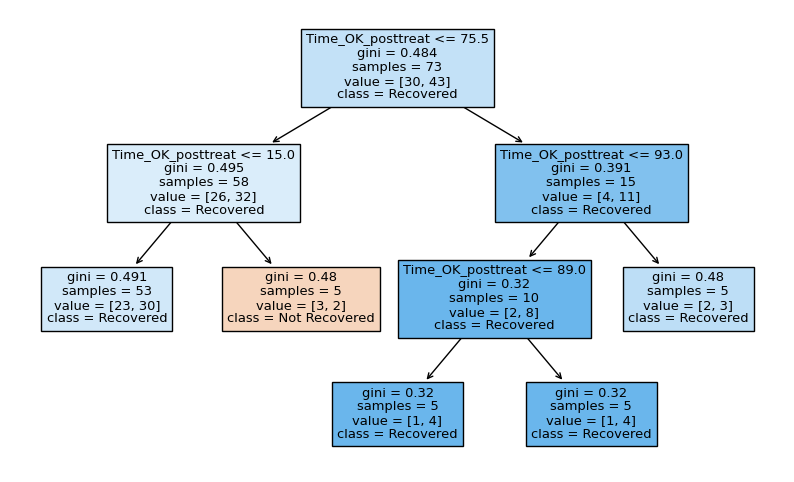

                 Model  Accuracy  Precision    Recall  Specificity        F1
0  Logistic Regression   0.75000   0.739130  0.894737     0.538462  0.809524
1        Decision Tree   0.71875   0.692308  0.947368     0.384615  0.800000
2              XGBoost   0.71875   0.708333  0.894737     0.461538  0.790698
3           Null Model   0.59375   0.593750  1.000000     0.000000  0.745098


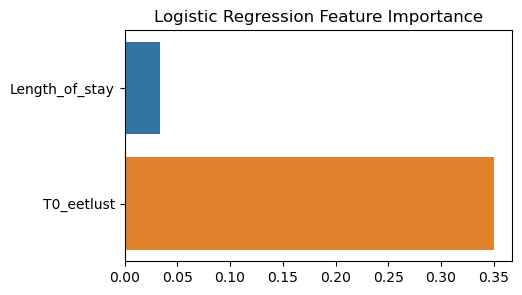

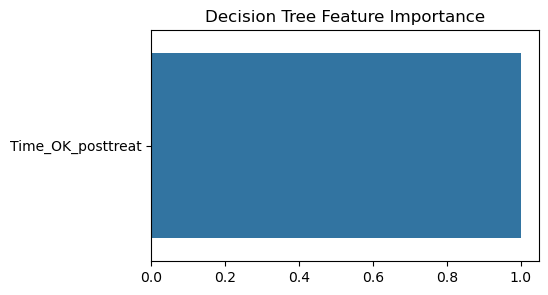

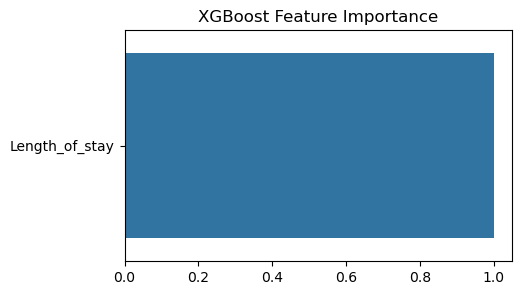

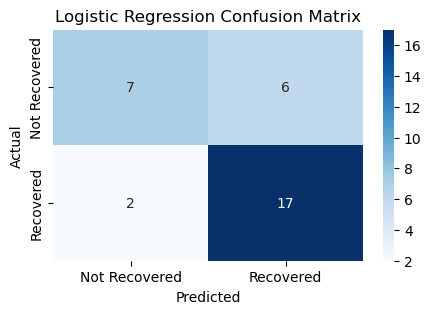

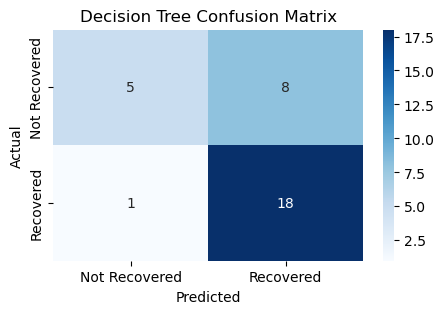

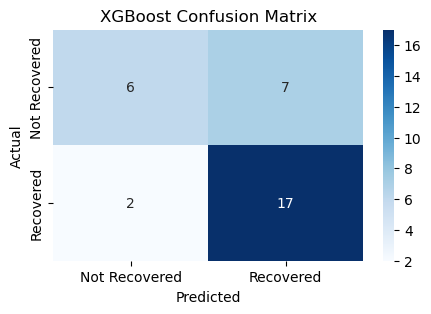

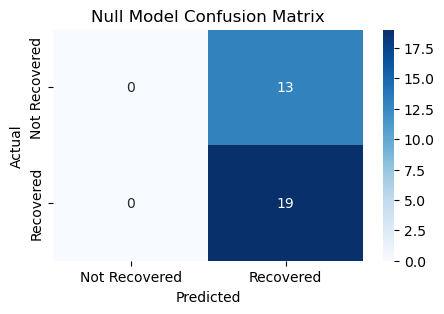

In [32]:
predictors = [
    'pat_sexe', 'T0_age', 'T0_BMI', 'Tumorlocation_strat', 'T0_Tumorsize', 'T0_ASA',
    'OK_pretreatment', 'Time_pretreat_OK', 'OK_Technique', 'OK_Duration_min', 
    'Complications', 'AMEXO_8_day1', 'AMEXO_9_day2', 'Length_of_stay', 
    'OK_posttreatment', 'Time_OK_posttreat', 'T0_sondevoeding', 'T0_eetlust'
]

# Filter the dataset to only include these predictors
X_train_filtered = X_train[predictors]
X_test_filtered = X_test[predictors]

# Forward feature selection
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    best_features, initial_features, best_score = [], [], 0
    while True:
        scores = [(accuracy_score(y_test, model.fit(X_train[initial_features + [f]], y_train).predict(X_test[initial_features + [f]])), f) for f in X_train.columns if f not in initial_features]
        if not scores: break
        current_score, best_feature = sorted(scores, reverse=True)[0]
        if current_score > best_score:
            best_score = current_score
            initial_features.append(best_feature)
            best_features.append(best_feature)
        else: break
    return best_features

# Metrics function
def calculate_metrics(y_true, y_pred):
    acc, prec, rec, f1 = accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'Specificity': tn / (tn + fp), 'F1': f1}

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recovered', 'Recovered'], yticklabels=['Not Recovered', 'Recovered'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Train and evaluate models
def train_evaluate_model(model, name):
    features = forward_feature_selection(model, X_train_filtered, y_train, X_test_filtered, y_test)
    model.fit(X_train_filtered[features], y_train)
    y_pred = model.predict(X_test_filtered[features])
    metrics = calculate_metrics(y_test, y_pred)
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else np.abs(model.coef_[0])
    return metrics, features, importances

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
metrics_log_reg, features_log_reg, importances_log_reg = train_evaluate_model(log_reg, 'Logistic Regression')

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15, min_samples_leaf=5)
metrics_tree, features_tree, importances_tree = train_evaluate_model(tree_model, 'Decision Tree')

# Plot Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(tree_model, feature_names=features_tree, class_names=['Not Recovered', 'Recovered'], filled=True)
plt.show()

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
metrics_xgb, features_xgb, importances_xgb = train_evaluate_model(xgb_model, 'XGBoost')

# Null Model
class NullModel:  # Dummy model that predicts the majority class
    def fit(self, X, y): self.mode = y.mode()[0]
    def predict(self, X): return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)
y_test_pred_null = null_model.predict(X_test)
metrics_null = calculate_metrics(y_test, y_test_pred_null)

# Feature importance plot
def plot_feature_importance(importances, features, title):
    plt.figure(figsize=(5, 3))
    sns.barplot(x=importances, y=features)
    plt.title(f'{title} Feature Importance')
    plt.show()

# Display results and plots
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Null Model'],
    'Accuracy': [metrics_log_reg['Accuracy'], metrics_tree['Accuracy'], metrics_xgb['Accuracy'], metrics_null['Accuracy']],
    'Precision': [metrics_log_reg['Precision'], metrics_tree['Precision'], metrics_xgb['Precision'], metrics_null['Precision']],
    'Recall': [metrics_log_reg['Recall'], metrics_tree['Recall'], metrics_xgb['Recall'], metrics_null['Recall']],
    'Specificity': [metrics_log_reg['Specificity'], metrics_tree['Specificity'], metrics_xgb['Specificity'], metrics_null['Specificity']],
    'F1': [metrics_log_reg['F1'], metrics_tree['F1'], metrics_xgb['F1'], metrics_null['F1']]
})
print(metrics_df)

plot_feature_importance(importances_log_reg, features_log_reg, 'Logistic Regression')
plot_feature_importance(importances_tree, features_tree, 'Decision Tree')
plot_feature_importance(importances_xgb, features_xgb, 'XGBoost')

plot_conf_matrix(y_test, log_reg.predict(X_test_filtered[features_log_reg]), 'Logistic Regression')
plot_conf_matrix(y_test, tree_model.predict(X_test_filtered[features_tree]), 'Decision Tree')
plot_conf_matrix(y_test, xgb_model.predict(X_test_filtered[features_xgb]), 'XGBoost')
plot_conf_matrix(y_test, y_test_pred_null, 'Null Model')
